# Computing and visulatizing the most important words in online news

This example shows that functions can hide a lot of complexity.
* E.g., we can download remote data by just invoking a function
* In particular, in this example we will use the online service [NewsAPI](https://newsapi.org/)
  * Which allows us to download recent online news

This document has been __created by Daniele Licari__

## The modules we need to use

In [17]:
#import sys
#!{sys.executable} -m pip install newsapi-python
#!{sys.executable} -m pip install wordcloud

In [18]:
# integrating News API into your Python application 
from newsapi import NewsApiClient 
newsapi = NewsApiClient(api_key='aedb6aa9bebb4011a4eb5447019dd592')

# creating wordclouds into your Python application 
from wordcloud import WordCloud, STOPWORDS

# regular expression 
import re

import matplotlib.pyplot as plt

__NewsApiClient__ is a local client for the online service [__NewsAPI__](https://newsapi.org/) that allows you to get news from [eveywhere in the world](https://newsapi.org/sources)
* Intuitively, an online service is like an online function running in a remote server
* A local client is a piece of code runnning in your machine that communicates with the online service
  * It allows you to easily interact with the online service
  * The interaction is typically done through a set of message exchanges as prescribed by the APIs of the service
* The argument `api_key` is a univoque identifier 
  * necessary when making requests to be identified
  * can be obtained registering [here](https://newsapi.org/register)
  
There exist many online services accessible with Python
* Most of them follows this api-key approach
* E.g. to enforce subscriptions
* In our case, __we are using a free subscription that allows us to only get the first 250 characters from a news item__

## Implementing two functions for data cleaning

__Stop words__ are usually the most common in any text ( like “the”, “of”, “to” and “and”), 
* They don’t tell us much about the actual content in a text
* These are the words we want to ignore - this is our data cleaning

We want to find the words that will help us differentiate a text from texts that are about different subjects. 
* __We will filter out the common (function) words__. Words that are ignored like this are known as stop words.  
* Of course, we are going to use a function for doing this

Furthermore, we want to ignore punctuations 
* A __regular expression__ is string able to represent many other strings that _match it_
* We are going to use it to delete all punctuations from a string

In [19]:
# to remove STOPWORDS
def removeStopwords(wordlist):
    return [w for w in wordlist if w not in STOPWORDS]

# to remove Punctuations
def removePunctuations(txt):
    return re.sub(r'[^\w\s]','',txt)  # all non-alphanumerics are replaced with a blank space using re.

## Data loading

We first get the most relevant article about coronavirus, published in usa-today
* This looks like a normal function invokation
* But under the hood a lot happens to contact the remote service

Luckily, the function `get_everything` hides this complexity to us

In [20]:
json_data = newsapi.get_everything(q='coronavirus',        # All the articles that contain this word
                                    language='en',
                                    sources = 'usa-today', # The newspaper of interest
                                    page_size=1,           # Get only one article
                                    sort_by='relevancy' 
                                    )
#There exist many more parameters allowing us the ask for more articles, different sources, etc

The return value `json_data` is just a dictionary collecting information about the remote request

In [21]:
print(type(json_data))
print()
print('The status of the request is',json_data['status'],'There are ',json_data['totalResults'],'articles matching the request.')
print('We got',len(json_data['articles']),'article')
print()
print(json_data)

<class 'dict'>

The status of the request is ok There are  2620 articles matching the request.
We got 1 article

{'status': 'ok', 'totalResults': 2620, 'articles': [{'source': {'id': 'usa-today', 'name': 'USA Today'}, 'author': 'USA TODAY, John Bacon, USA TODAY', 'title': 'Coronavirus live updates: Fauci, other health officials testify before Senate committee; will pandemic claim a major US airline?', 'description': 'Top key members of the coronavirus task force will testify before a Senate committee. The MLB hopes for games in July. The latest coronavirus updates.', 'url': 'https://www.usatoday.com/story/news/health/2020/05/12/coronavirus-update-fauci-senate-testing-stimulus-payments/3109600001/', 'urlToImage': 'https://www.gannett-cdn.com/presto/2020/05/12/USAT/63f008d5-2907-4d59-a731-c0ebc69b2e4d-AFP_AFP_1RE5Q9.JPG?crop=5489,3088,x0,y0&width=3200&height=1680&fit=bounds', 'publishedAt': '2020-05-12T10:03:31Z', 'content': "White House has confirmed a second coronavirus case among West

We can ignore all the metadata (i.e. the data about the remote request) and focus on the actual articles only

In [22]:
articles = json_data['articles'] 

#Get the content of the first article
content = articles[0]['content']
print(content)
print(len(content))

# #print content article 
# for a in json_data['articles']:
#     print(a['content'])

White House has confirmed a second coronavirus case among West Wing staff, this time in VP Mike Pence's office. President Trump addresses concerns.
USA TODAY
Top federal health officials will testi… [+12755 chars]
215


## Data cleaning, manipulation and visualization 

Now begins the funny part
1. Let's clean the data removing not interesting words
2. Let's compute the frequency of use of words
3. Let's visualize graphically the computed analysis - Word Cloud

In [23]:
# 1 cleaning data
print('Before cleaning')
print(content)
print()

content_to_clean = content.lower()
clean_content = removePunctuations(content_to_clean).split()
clean_content = removeStopwords(clean_content)
print('After cleaning')
print(clean_content)
print()

Before cleaning
White House has confirmed a second coronavirus case among West Wing staff, this time in VP Mike Pence's office. President Trump addresses concerns.
USA TODAY
Top federal health officials will testi… [+12755 chars]

After cleaning
['white', 'house', 'confirmed', 'second', 'coronavirus', 'case', 'among', 'west', 'wing', 'staff', 'time', 'vp', 'mike', 'pences', 'office', 'president', 'trump', 'addresses', 'concerns', 'usa', 'today', 'top', 'federal', 'health', 'officials', 'will', 'testi', '12755', 'chars']



In [24]:
# 2 computing word-frequency pairs
wordcount = {}
for w in clean_content:
    if w in wordcount:
        wordcount[w] += 1
    else:
        wordcount[w] = 1

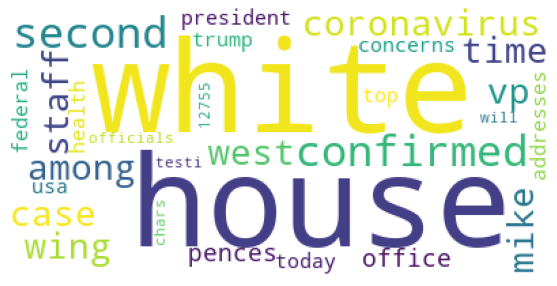

In [25]:
# 3 visualizing the analysisis in a Word Cloud
wc = WordCloud(background_color='white').generate_from_frequencies(wordcount)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.show()